# Spark DataFrames

In [140]:
import findspark
findspark.init()

In [141]:
from pyspark.sql import SparkSession
from pyspark.conf import SparkConf
from pyspark.sql.types import * 
import pyspark.sql.functions as F
from pyspark.sql.functions import col, asc,desc
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from pyspark.sql import SQLContext
from pyspark.mllib.stat import Statistics
import pandas as pd
from pyspark.sql.functions import udf
spark=SparkSession.builder \
.master ("local[*]")\
.appName("part3")\
.getOrCreate()

In [142]:
sc=spark.sparkContext
sqlContext=SQLContext(sc)

### Read File

In [143]:
df=spark.read \
 .option("header","True")\
 .option("inferSchema","True")\
 .option("sep",",")\
 .csv("/Users/gulcanogundur/Downloads/diabetes.csv")

## Show File

In [144]:
df.show()

+-----------+-------+-------------+-------------+-------+----+------------------------+---+-------+
|Pregnancies|Glucose|BloodPressure|SkinThickness|Insulin| BMI|DiabetesPedigreeFunction|Age|Outcome|
+-----------+-------+-------------+-------------+-------+----+------------------------+---+-------+
|          6|    148|           72|           35|      0|33.6|                   0.627| 50|      1|
|          1|     85|           66|           29|      0|26.6|                   0.351| 31|      0|
|          8|    183|           64|            0|      0|23.3|                   0.672| 32|      1|
|          1|     89|           66|           23|     94|28.1|                   0.167| 21|      0|
|          0|    137|           40|           35|    168|43.1|                   2.288| 33|      1|
|          5|    116|           74|            0|      0|25.6|                   0.201| 30|      0|
|          3|     78|           50|           32|     88|31.0|                   0.248| 26|      1|


In [145]:
df.printSchema()

root
 |-- Pregnancies: integer (nullable = true)
 |-- Glucose: integer (nullable = true)
 |-- BloodPressure: integer (nullable = true)
 |-- SkinThickness: integer (nullable = true)
 |-- Insulin: integer (nullable = true)
 |-- BMI: double (nullable = true)
 |-- DiabetesPedigreeFunction: double (nullable = true)
 |-- Age: integer (nullable = true)
 |-- Outcome: integer (nullable = true)



In [146]:
numeric_features = [t[0] for t in df.dtypes if t[1] == 'int']
df.select(numeric_features).describe().toPandas().transpose()

,0,1,2,3,4
summary,count,mean,stddev,min,max
Pregnancies,768,3.8450520833333335,3.36957806269887,0,17
Glucose,768,120.89453125,31.97261819513622,0,199
BloodPressure,768,69.10546875,19.355807170644777,0,122
SkinThickness,768,20.536458333333332,15.952217567727642,0,99
Insulin,768,79.79947916666667,115.24400235133803,0,846
Age,768,33.240885416666664,11.760231540678689,21,81
Outcome,768,0.3489583333333333,0.476951377242799,0,1


In [147]:
df.show()

+-----------+-------+-------------+-------------+-------+----+------------------------+---+-------+
|Pregnancies|Glucose|BloodPressure|SkinThickness|Insulin| BMI|DiabetesPedigreeFunction|Age|Outcome|
+-----------+-------+-------------+-------------+-------+----+------------------------+---+-------+
|          6|    148|           72|           35|      0|33.6|                   0.627| 50|      1|
|          1|     85|           66|           29|      0|26.6|                   0.351| 31|      0|
|          8|    183|           64|            0|      0|23.3|                   0.672| 32|      1|
|          1|     89|           66|           23|     94|28.1|                   0.167| 21|      0|
|          0|    137|           40|           35|    168|43.1|                   2.288| 33|      1|
|          5|    116|           74|            0|      0|25.6|                   0.201| 30|      0|
|          3|     78|           50|           32|     88|31.0|                   0.248| 26|      1|


from pyspark.ml.feature import Imputer
imputer=Imputer(inputCols=["Glucose","BloodPressure","SkinThickness","BMI","Insulin"],outputCols=["Glucose","BloodPressure","SkinThickness","BMI","Insulin"])
model=imputer.fit(df)
raw_data=model.transform(df)
raw_data.show(5)

## Statistics

In [148]:
print(df.count()) #Row Count
print(len(df.columns)) #Column Count

768
9


In [149]:
df.groupby("Outcome").count().show()

+-------+-----+
|Outcome|count|
+-------+-----+
|      1|  268|
|      0|  500|
+-------+-----+



## String Columns > Integer Columns

In [150]:
def udf_multiple(age):
  if (age <= 25):
    return 'Under 25'
  elif (age >= 25 and age <= 35):
    return 'Between 25 and 35'
  elif (age > 35 and age < 50):
    return 'Between 36 and 49'
  elif (age >= 50):
    return 'Over 50'
  else: return 'N/A'

education_udf = udf(udf_multiple)
df=df.withColumn("Age_udf", education_udf('Age'))

In [151]:
from pyspark.sql import functions as F
from pyspark.sql.functions import rank,sum,col
from pyspark.sql import Window

window = Window.rowsBetween(Window.unboundedPreceding,Window.unboundedFollowing)
tab = df.select(['Age_udf','Glucose']).\
   groupBy('Age_udf').\
   agg(F.count('Glucose').alias('Glucose_COUNT'),
       F.mean('Glucose').alias('Glucose_AVG'),
       F.min('Glucose').alias('Glucose_MIN'),
       F.max('Glucose').alias('Glucose_MAX')).\
   withColumn('total',sum(col('Glucose_COUNT')).over(window)).\
   withColumn('Percent',col('Glucose_COUNT')*100/col('total')).\
   drop(col('total')).sort(desc("Percent"))

In [152]:
tab.show()

+-----------------+-------------+------------------+-----------+-----------+------------------+
|          Age_udf|Glucose_COUNT|       Glucose_AVG|Glucose_MIN|Glucose_MAX|           Percent|
+-----------------+-------------+------------------+-----------+-----------+------------------+
|         Under 25|          267|110.71910112359551|          0|        199|         34.765625|
|Between 25 and 35|          231|121.67099567099567|         71|        198|         30.078125|
|Between 36 and 49|          181|125.74033149171271|          0|        197|23.567708333333332|
|          Over 50|           89| 139.5505617977528|         57|        197|11.588541666666666|
+-----------------+-------------+------------------+-----------+-----------+------------------+



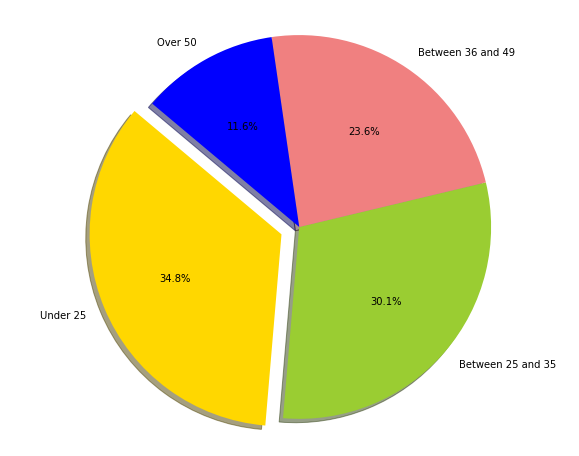

In [153]:
# Data to plot
labels = list(tab.select('Age_udf').distinct().toPandas()['Age_udf'])
sizes =  list(tab.select('Percent').distinct().toPandas()['Percent'])
colors = ['gold', 'yellowgreen', 'lightcoral','blue', 'lightskyblue','green','red']
explode = (0.1, 0.0, 0 ,0.0 )  # explode 1st slice

# Plot
plt.figure(figsize=(10,8))
plt.pie(sizes, explode=explode, labels=labels, colors=colors,
        autopct='%1.1f%%', shadow=True, startangle=140)

plt.axis('equal')
plt.show()

In [154]:
df.show()

+-----------+-------+-------------+-------------+-------+----+------------------------+---+-------+-----------------+
|Pregnancies|Glucose|BloodPressure|SkinThickness|Insulin| BMI|DiabetesPedigreeFunction|Age|Outcome|          Age_udf|
+-----------+-------+-------------+-------------+-------+----+------------------------+---+-------+-----------------+
|          6|    148|           72|           35|      0|33.6|                   0.627| 50|      1|          Over 50|
|          1|     85|           66|           29|      0|26.6|                   0.351| 31|      0|Between 25 and 35|
|          8|    183|           64|            0|      0|23.3|                   0.672| 32|      1|Between 25 and 35|
|          1|     89|           66|           23|     94|28.1|                   0.167| 21|      0|         Under 25|
|          0|    137|           40|           35|    168|43.1|                   2.288| 33|      1|Between 25 and 35|
|          5|    116|           74|            0|      0

# The correlation between the numerical values was investigated

In [155]:
df_corr=df['Pregnancies',
 'Glucose',
 'BloodPressure',
 'SkinThickness',
 'Insulin',
 'BMI',
 'DiabetesPedigreeFunction',
 'Age']

In [156]:
df_corr.show()

+-----------+-------+-------------+-------------+-------+----+------------------------+---+
|Pregnancies|Glucose|BloodPressure|SkinThickness|Insulin| BMI|DiabetesPedigreeFunction|Age|
+-----------+-------+-------------+-------------+-------+----+------------------------+---+
|          6|    148|           72|           35|      0|33.6|                   0.627| 50|
|          1|     85|           66|           29|      0|26.6|                   0.351| 31|
|          8|    183|           64|            0|      0|23.3|                   0.672| 32|
|          1|     89|           66|           23|     94|28.1|                   0.167| 21|
|          0|    137|           40|           35|    168|43.1|                   2.288| 33|
|          5|    116|           74|            0|      0|25.6|                   0.201| 30|
|          3|     78|           50|           32|     88|31.0|                   0.248| 26|
|         10|    115|            0|            0|      0|35.3|                  

In [157]:
col_names =df_corr.columns
features = df_corr.rdd.map(lambda row: row[0:])
corr_mat=Statistics.corr(features, method="pearson")
corr_df = pd.DataFrame(corr_mat)
corr_df.index, corr_df.columns = col_names, col_names

print(corr_df.to_string())

                          Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin       BMI  DiabetesPedigreeFunction       Age
Pregnancies                  1.000000  0.129459       0.141282      -0.081672 -0.073535  0.017683                 -0.033523  0.544341
Glucose                      0.129459  1.000000       0.152590       0.057328  0.331357  0.221071                  0.137337  0.263514
BloodPressure                0.141282  0.152590       1.000000       0.207371  0.088933  0.281805                  0.041265  0.239528
SkinThickness               -0.081672  0.057328       0.207371       1.000000  0.436783  0.392573                  0.183928 -0.113970
Insulin                     -0.073535  0.331357       0.088933       0.436783  1.000000  0.197859                  0.185071 -0.042163
BMI                          0.017683  0.221071       0.281805       0.392573  0.197859  1.000000                  0.140647  0.036242
DiabetesPedigreeFunction    -0.033523  0.137337       0.041265

In [158]:
from pyspark.sql.functions import udf
y_udf = udf(lambda y: "No" if y==0 else "yes", StringType())

df=df.withColumn("HasDiabities", y_udf('OutCome')).drop("OutCome")

In [159]:
df.printSchema()

root
 |-- Pregnancies: integer (nullable = true)
 |-- Glucose: integer (nullable = true)
 |-- BloodPressure: integer (nullable = true)
 |-- SkinThickness: integer (nullable = true)
 |-- Insulin: integer (nullable = true)
 |-- BMI: double (nullable = true)
 |-- DiabetesPedigreeFunction: double (nullable = true)
 |-- Age: integer (nullable = true)
 |-- Age_udf: string (nullable = true)
 |-- HasDiabities: string (nullable = true)



In [160]:
df=df.drop("Age")

In [161]:
from pyspark.ml.feature import OneHotEncoderEstimator, StringIndexer, VectorAssembler
categoricalColumns = [ 'Age_udf']
stages = []
for categoricalCol in categoricalColumns:
    stringIndexer = StringIndexer(inputCol = categoricalCol, outputCol = categoricalCol + 'Index')
    encoder = OneHotEncoderEstimator(inputCols=[stringIndexer.getOutputCol()], outputCols=[categoricalCol + "classVec"])
    stages += [stringIndexer, encoder]
label_stringIdx = StringIndexer(inputCol = 'HasDiabities', outputCol = 'label')
stages += [label_stringIdx]
numericCols = ["Pregnancies", 'Glucose', 'BloodPressure', 'SkinThickness','Insulin','BMI','DiabetesPedigreeFunction']
assemblerInputs = [c + "classVec" for c in categoricalColumns] + numericCols
assembler = VectorAssembler(inputCols=assemblerInputs, outputCol="features")
stages += [assembler]

In [162]:
cols = df.columns

In [163]:
cols

['Pregnancies',
 'Glucose',
 'BloodPressure',
 'SkinThickness',
 'Insulin',
 'BMI',
 'DiabetesPedigreeFunction',
 'Age_udf',
 'HasDiabities']

In [164]:
from pyspark.ml import Pipeline
pipeline = Pipeline(stages = stages)
pipelineModel = pipeline.fit(df)
df = pipelineModel.transform(df)
selectedCols = ['label', 'features'] + cols
df = df.select(selectedCols)
df.printSchema()

root
 |-- label: double (nullable = false)
 |-- features: vector (nullable = true)
 |-- Pregnancies: integer (nullable = true)
 |-- Glucose: integer (nullable = true)
 |-- BloodPressure: integer (nullable = true)
 |-- SkinThickness: integer (nullable = true)
 |-- Insulin: integer (nullable = true)
 |-- BMI: double (nullable = true)
 |-- DiabetesPedigreeFunction: double (nullable = true)
 |-- Age_udf: string (nullable = true)
 |-- HasDiabities: string (nullable = true)



In [165]:
pd.DataFrame(df.take(5), columns=df.columns).transpose()

,0,1,2,3,4
label,1,0,1,0,1
features,"[0.0, 0.0, 0.0, 6.0, 148.0, 72.0, 35.0, 0.0, 3...","[0.0, 1.0, 0.0, 1.0, 85.0, 66.0, 29.0, 0.0, 26...","[0.0, 1.0, 0.0, 8.0, 183.0, 64.0, 0.0, 0.0, 23...","[1.0, 0.0, 0.0, 1.0, 89.0, 66.0, 23.0, 94.0, 2...","[0.0, 1.0, 0.0, 0.0, 137.0, 40.0, 35.0, 168.0,..."
Pregnancies,6,1,8,1,0
Glucose,148,85,183,89,137
BloodPressure,72,66,64,66,40
SkinThickness,35,29,0,23,35
Insulin,0,0,0,94,168
BMI,33.6,26.6,23.3,28.1,43.1
DiabetesPedigreeFunction,0.627,0.351,0.672,0.167,2.288
Age_udf,Over 50,Between 25 and 35,Between 25 and 35,Under 25,Between 25 and 35


In [166]:
df.show()

+-----+--------------------+-----------+-------+-------------+-------------+-------+----+------------------------+-----------------+------------+
|label|            features|Pregnancies|Glucose|BloodPressure|SkinThickness|Insulin| BMI|DiabetesPedigreeFunction|          Age_udf|HasDiabities|
+-----+--------------------+-----------+-------+-------------+-------------+-------+----+------------------------+-----------------+------------+
|  1.0|[0.0,0.0,0.0,6.0,...|          6|    148|           72|           35|      0|33.6|                   0.627|          Over 50|         yes|
|  0.0|[0.0,1.0,0.0,1.0,...|          1|     85|           66|           29|      0|26.6|                   0.351|Between 25 and 35|          No|
|  1.0|[0.0,1.0,0.0,8.0,...|          8|    183|           64|            0|      0|23.3|                   0.672|Between 25 and 35|         yes|
|  0.0|[1.0,0.0,0.0,1.0,...|          1|     89|           66|           23|     94|28.1|                   0.167|         U

In [167]:
train, test = df.randomSplit([0.8, 0.2], seed = 2018)
print("Training Dataset Count: " + str(train.count()))
print("Test Dataset Count: " + str(test.count()))

Training Dataset Count: 627
Test Dataset Count: 141


In [168]:
train.groupby("HasDiabities").count().show()

+------------+-----+
|HasDiabities|count|
+------------+-----+
|          No|  406|
|         yes|  221|
+------------+-----+



In [169]:
from pyspark.ml.classification import LogisticRegression
lr = LogisticRegression(featuresCol = 'features', labelCol = 'label', maxIter=5)
lrModel = lr.fit(train)

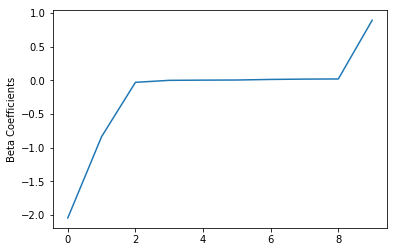

In [170]:
import matplotlib.pyplot as plt
import numpy as np
beta = np.sort(lrModel.coefficients)
plt.plot(beta)
plt.ylabel('Beta Coefficients')
plt.show()

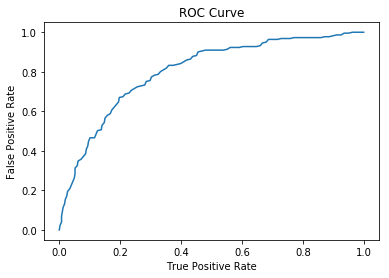

Training set areaUnderROC: 0.802236809843301


In [171]:
trainingSummary = lrModel.summary
roc = trainingSummary.roc.toPandas()
plt.plot(roc['FPR'],roc['TPR'])
plt.ylabel('False Positive Rate')
plt.xlabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()
print('Training set areaUnderROC: ' + str(trainingSummary.areaUnderROC))

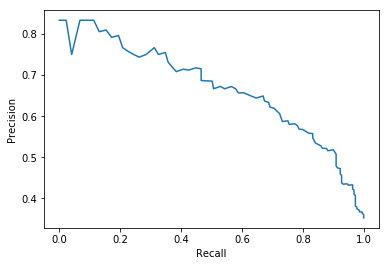

In [172]:
pr = trainingSummary.pr.toPandas()
plt.plot(pr['recall'],pr['precision'])
plt.ylabel('Precision')
plt.xlabel('Recall')
plt.show()

In [173]:
predictions = lrModel.transform(test)
predictions.select('Insulin', 'Glucose', 'label', 'rawPrediction', 'prediction', 'probability').show(10)

+-------+-------+-----+--------------------+----------+--------------------+
|Insulin|Glucose|label|       rawPrediction|prediction|         probability|
+-------+-------+-----+--------------------+----------+--------------------+
|      0|    125|  0.0|[3.14296543686162...|       0.0|[0.95863064386955...|
|      0|     91|  0.0|[1.61743992866134...|       0.0|[0.83444176200666...|
|      0|    129|  0.0|[-2.2927853987513...|       1.0|[0.09172223636012...|
|      0|    114|  0.0|[0.09659684428291...|       0.0|[0.52413045065171...|
|      0|    147|  0.0|[-0.0860218829928...|       1.0|[0.47850778073074...|
|      0|    114|  0.0|[0.91405926200945...|       0.0|[0.71383009459694...|
|      0|    166|  0.0|[-0.5408297714493...|       1.0|[0.36799457739760...|
|      0|    110|  0.0|[0.60144451838423...|       0.0|[0.64598671968964...|
|      0|    112|  0.0|[-0.0270060073692...|       1.0|[0.49324890846403...|
|      0|    120|  0.0|[0.36769195994791...|       0.0|[0.59090115708220...|

In [ ]:
from pyspark.ml.evaluation import BinaryClassificationEvaluator
evaluator = BinaryClassificationEvaluator()
print('Test Area Under ROC', evaluator.evaluate(predictions))

Test Area Under ROC 0.7704843820733362


In [ ]:
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator

# Create ParamGrid for Cross Validation
paramGrid = (ParamGridBuilder()
             .addGrid(lr.regParam, [0.01, 0.5, 2.0])
             .addGrid(lr.elasticNetParam, [0.0, 0.5, 1.0])
             .addGrid(lr.maxIter, [1, 5, 10])
             .build())

cv = CrossValidator(estimator=lr, estimatorParamMaps=paramGrid, evaluator=evaluator, numFolds=5)

cvModel = cv.fit(train)
predictions = cvModel.transform(test)

In [ ]:
print('Test Area Under ROC', evaluator.evaluate(predictions))